In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import seaborn as sns
import Augmentor
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/home/jacob/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-12-16 12:40:47.771679: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-16 12:40:47.771704: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-16 12:40:47.772587: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-16 12:40:47.778241: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary i

In [2]:
train_dir = "birds/train/"
test_dir = "birds/test/"
valid_dir = "birds/valid"

In [3]:
train_folder = os.listdir(train_dir)
test_folder = os.listdir(test_dir)
valid_folder = os.listdir(valid_dir)
print(f'Species in Train Set: {len(train_folder)}')
print(f'Species in Test Set: {len(test_folder)}')
print(f'Species in Valid Set: {len(valid_folder)}')

Species in Train Set: 525
Species in Test Set: 525
Species in Valid Set: 525


In [4]:
def get_data(input_dir,folders, img_names, img_labels, img_height, img_width, img_color):
    size = 224,224
    for folder in folders:
        for file in os.listdir(os.path.join(input_dir,folder)):
            if file.endswith("jpg"):
                img_names.append(os.path.join(input_dir,folder,file))
                img_labels.append(folder)
                img = cv2.imread(os.path.join(input_dir,folder,file))
                img_height.append(img.shape[0])
                img_width.append(img.shape[1])
                img_color.append(img.shape[2])
            else:
                continue
    return img_names, img_labels, img_height, img_width, img_color

In [27]:
train_names = []
train_labels = []
train_images_height = []
train_images_width = []
train_images_color = []

test_names = []
test_labels = []
test_images_height = []
test_images_width = []
test_images_color = []

valid_names = []
valid_labels = []
valid_images_height = []
valid_images_width = []
valid_images_color = []

train_names, train_labels, train_images_height, train_images_width, train_images_color = get_data(train_dir, train_folder, train_names, train_labels, train_images_height, train_images_width, train_images_color)
test_names, test_labels, test_images_height, test_images_width, test_images_color = get_data(test_dir, test_folder, test_names, test_labels, test_images_height, test_images_width, test_images_color)
valid_names, valid_labels, valid_images_height, valid_images_width, valid_images_color = get_data(valid_dir, valid_folder, valid_names, valid_labels, valid_images_height, valid_images_width, valid_images_color)

In [53]:
df_train_info = pd.DataFrame({"Species Name": train_labels, "Filepath": train_names})
df_test_info = pd.DataFrame({"Species Name": test_labels, "Filepath": test_names})
df_valid_info = pd.DataFrame({"Species Name": valid_labels, "Filepath": valid_names})

In [29]:
print(f"Size of train set: {df_train_info.shape[0]}")
print(f"Size of test set: {df_test_info.shape[0]}")
print(f"Size of valid set: {df_valid_info.shape[0]}")
print(f"Total images in set: {df_test_info.shape[0] + df_valid_info.shape[0] + df_train_info.shape[0]}")

Size of train set: 84635
Size of test set: 2625
Size of valid set: 2625
Total images in set: 89885


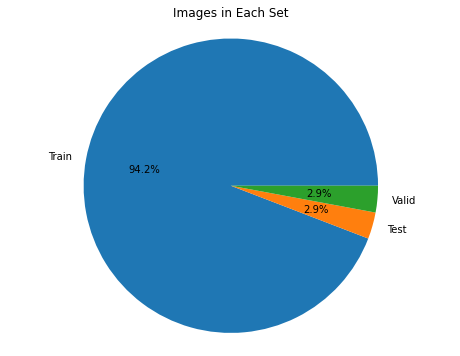

In [30]:
data_set_counts = [df_train_info.shape[0], df_test_info.shape[0], df_valid_info.shape[0]]

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(data_set_counts, labels=['Train', 'Test', 'Valid'], autopct='%1.1f%%')
plt.title('Images in Each Set')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
unique_train = np.unique(train_labels).astype(str)
unique_test = np.unique(test_labels).astype(str)
unique_valid = np.unique(valid_labels).astype(str)

# Find differences between unique_train and unique_test
diff_train_test = np.setdiff1d(unique_train, unique_test)

# Find differences between unique_train and unique_valid
diff_train_valid = np.setdiff1d(unique_train, unique_valid)

# Find differences between unique_test and unique_valid
diff_test_valid = np.setdiff1d(unique_test, unique_valid)

# Check if there are any differences
differences_exist = len(diff_train_test) > 0 or len(diff_train_valid) > 0 or len(diff_test_valid) > 0

if differences_exist:
    print("Differences between unique_train and unique_test:", diff_train_test)
    print("Differences between unique_train and unique_valid:", diff_train_valid)
    print("Differences between unique_test and unique_valid:", diff_test_valid)
else:
    print("No differences found.")

Differences between unique_train and unique_test: []
Differences between unique_train and unique_valid: ['PARAKETT  AUKLET']
Differences between unique_test and unique_valid: ['PARAKETT  AUKLET']


In [20]:
# Update filename 
os.rename(src="birds/test/PARAKETT  AUKLET",dst="birds/test/PARAKETT AUKLET")
os.rename(src="birds/train/PARAKETT  AUKLET",dst="birds/train/PARAKETT AUKLET")

In [46]:
def size_plots(dimensions):
    plt.figure(figsize=(8, 10))
    
    plt.subplot(3, 1, 1)
    sns.lineplot(x=dimensions.index, y=dimensions['height'], marker='o', sort=False)
    plt.title('Distribution of Heights')
    plt.xlabel('Index')
    plt.ylabel('Height')

    plt.subplot(3, 1, 2)
    sns.lineplot(x=dimensions.index, y=dimensions['width'], marker='o', sort=False)
    plt.title('Distribution of Width')
    plt.xlabel('Index')
    plt.ylabel('Width')

    plt.subplot(3, 1, 3)
    sns.lineplot(x=dimensions.index, y=dimensions['color'], marker='o', sort=False)
    plt.title('Distribution of Color values')
    plt.xlabel('Index')
    plt.ylabel('RGB')

    plt.tight_layout()  # Adjusts subplots to prevent overlapping
    plt.show()

    # Initialize variables to track max, min, and count
    max_height = float('-inf')  
    min_height = float('inf') 
    max_width = float('-inf')  
    min_width = float('inf')  
    count_not_224x224 = 0

    for index, row in dimensions.iterrows():
        height = row['height']
        width = row['width']

        # Update max and min height
        max_height = max(max_height, height)
        min_height = min(min_height, height)

        # Update max and min width
        max_width = max(max_width, width)
        min_width = min(min_width, width)

        # Count occurrences where neither height nor width is equal to 224
        if height != 224 or width != 224:
            count_not_224x224 += 1

    print("Image set dimensions")
    print(f"Maximum height: {max_height}")
    print(f"Minimum height: {min_height}")
    print(f"Maximum width: {max_width}")
    print(f"Minimum width: {min_width}")
    print(f"Count where neither height nor width is 224: {count_not_224x224}")

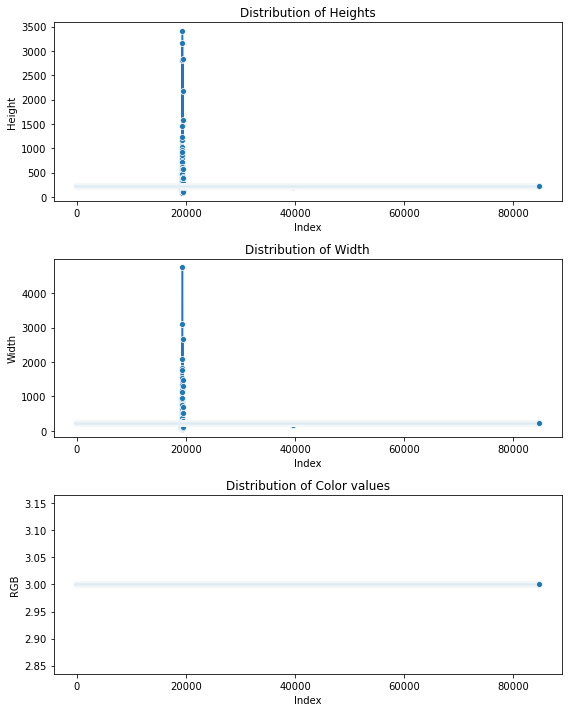

Image set dimensions
Maximum height: 3421
Minimum height: 83
Maximum width: 4763
Minimum width: 45
Count where neither height nor width is 224: 201


In [47]:
train_dimensions = pd.DataFrame({"height": train_images_height,
                                 "width": train_images_width,
                                "color": train_images_color})
size_plots(train_dimensions)

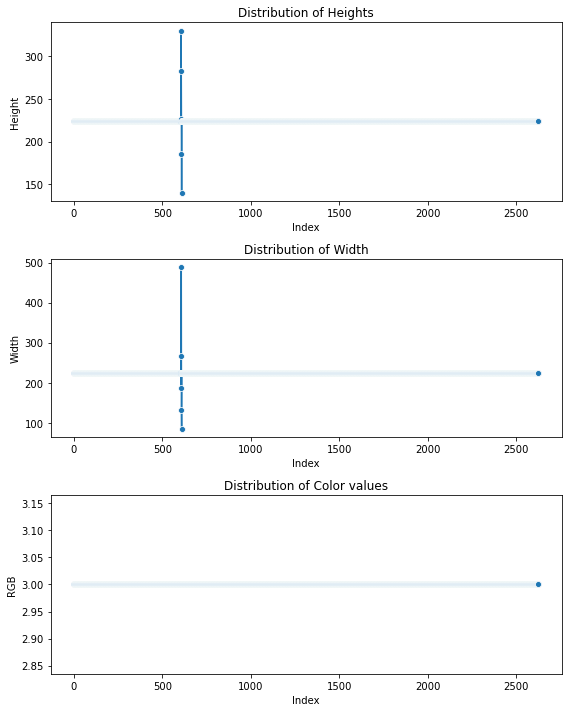

Image set dimensions
Maximum height: 330
Minimum height: 140
Maximum width: 489
Minimum width: 84
Count where neither height nor width is 224: 5


In [48]:
valid_dimensions = pd.DataFrame({"height": valid_images_height,
                                 "width": valid_images_width,
                                "color": valid_images_color})
size_plots(valid_dimensions)

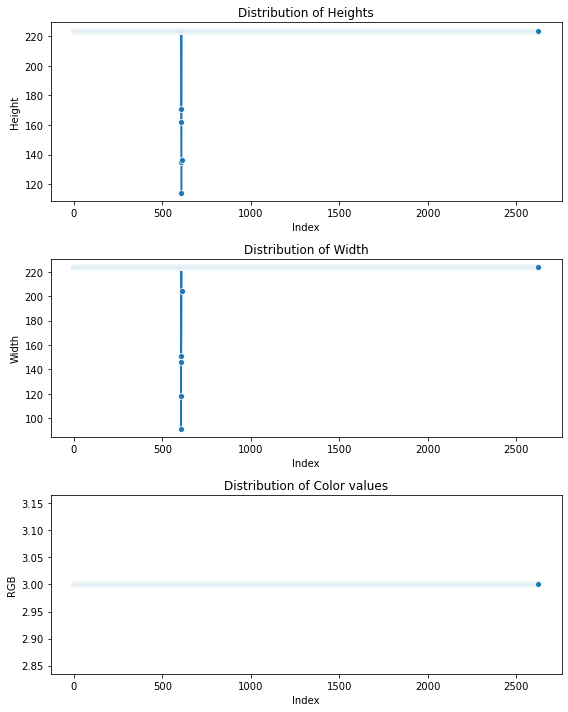

Image set dimensions
Maximum height: 224
Minimum height: 114
Maximum width: 224
Minimum width: 91
Count where neither height nor width is 224: 5


In [49]:
test_dimensions = pd.DataFrame({"height": test_images_height,
                                 "width": test_images_width, 
                                "color": test_images_color})
size_plots(test_dimensions)

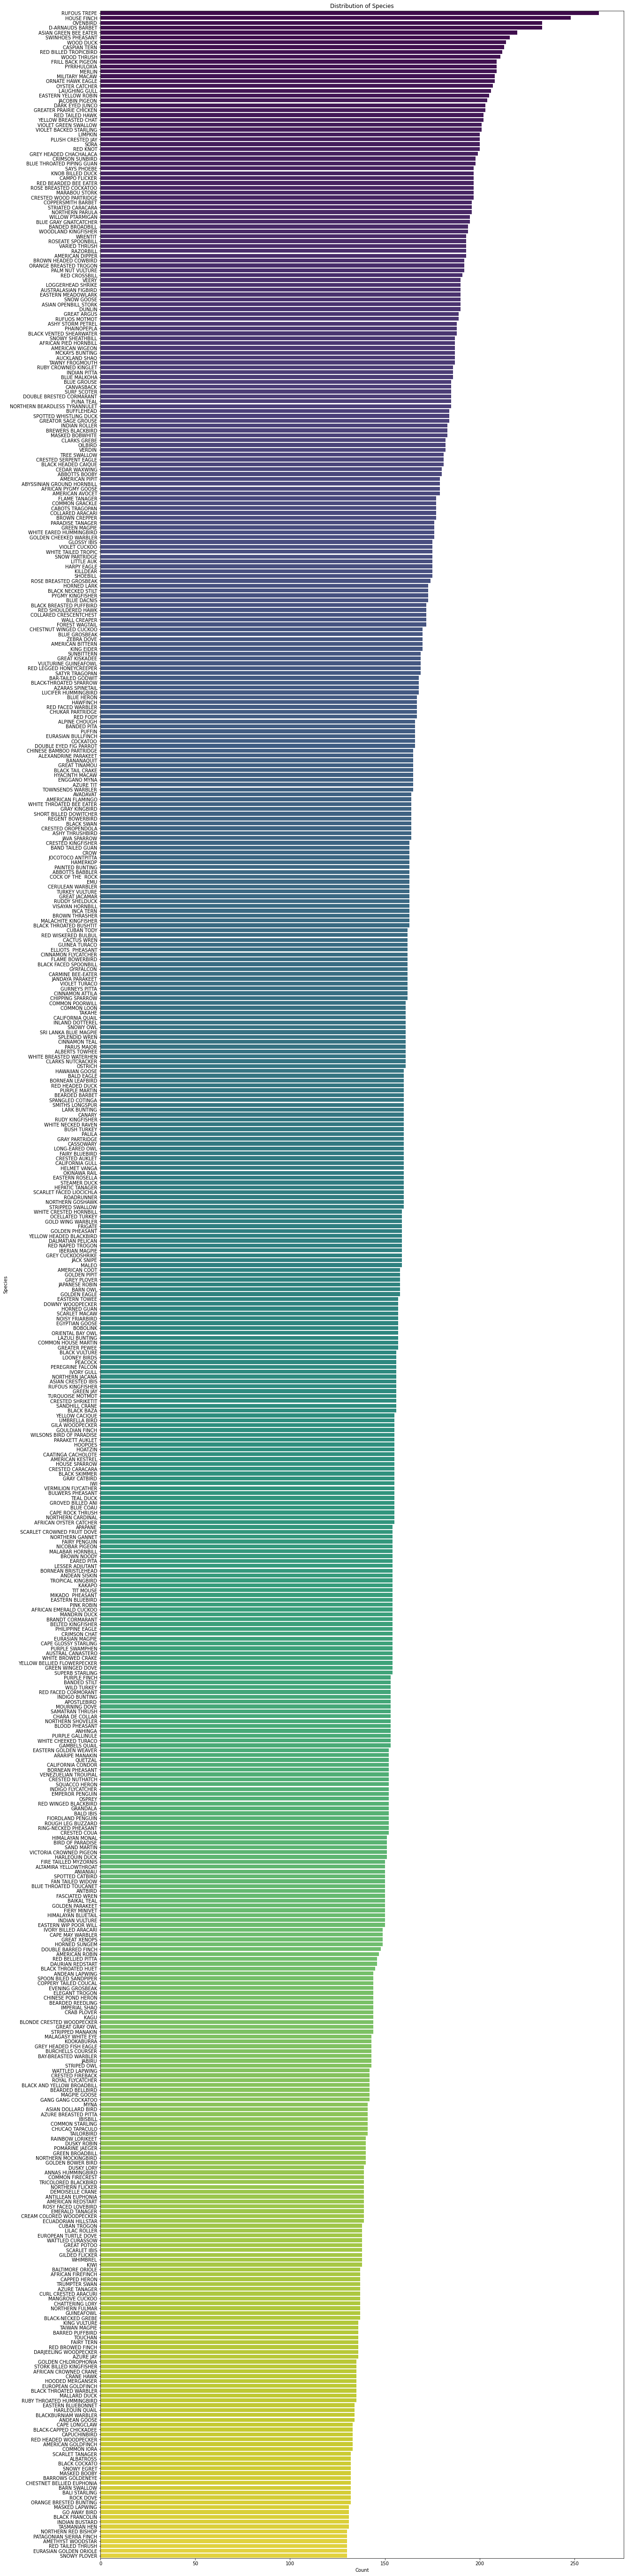

In [55]:
# Set the size of the plot
plt.figure(figsize=(20, 100))

# Create a horizontal bar plot with seaborn
sns.countplot(y='Species Name', data=df_train_info, order=df_train['Species'].value_counts().index, palette='viridis')

# Customize the plot
plt.title('Distribution of Species')
plt.xlabel('Count')
plt.ylabel('Species')

# Show the plot
plt.show()

In [57]:
df_train_info.groupby('Species Name')['Filepath'].nunique().sort_values()

Species Name
EURASIAN GOLDEN ORIOLE     130
RED TAILED THRUSH          130
SNOWY PLOVER               130
AMETHYST WOODSTAR          130
PATAGONIAN SIERRA FINCH    130
                          ... 
ASIAN GREEN BEE EATER      220
D-ARNAUDS BARBET           233
OVENBIRD                   233
HOUSE FINCH                248
RUFOUS TREPE               263
Name: Filepath, Length: 525, dtype: int64

In [8]:
def plot_class_hist(data_set):
    plt.figure(figsize=[20,12])
    
    sns.countplot(x='Species Name', data=data_set)
    plt.title('Distribution of Classes Valid')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.show()

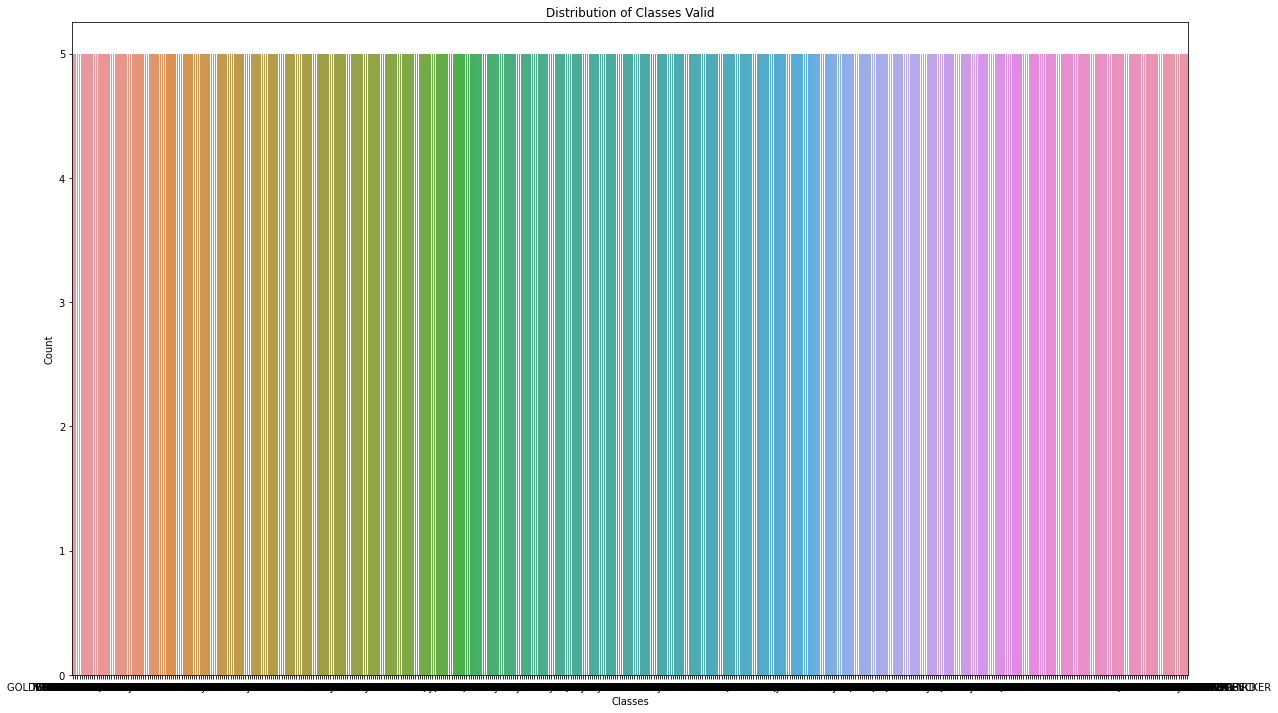

In [61]:
plot_class_hist(df_test_info)

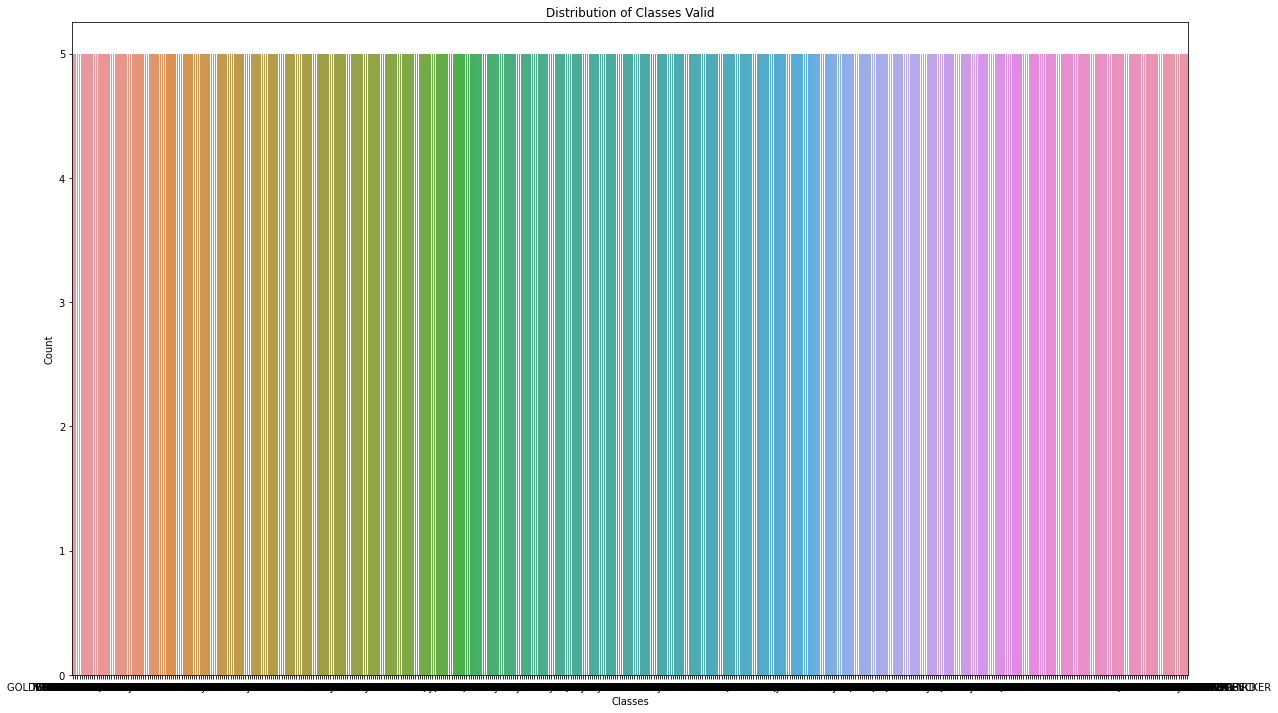

In [62]:
plot_class_hist(df_valid_info)

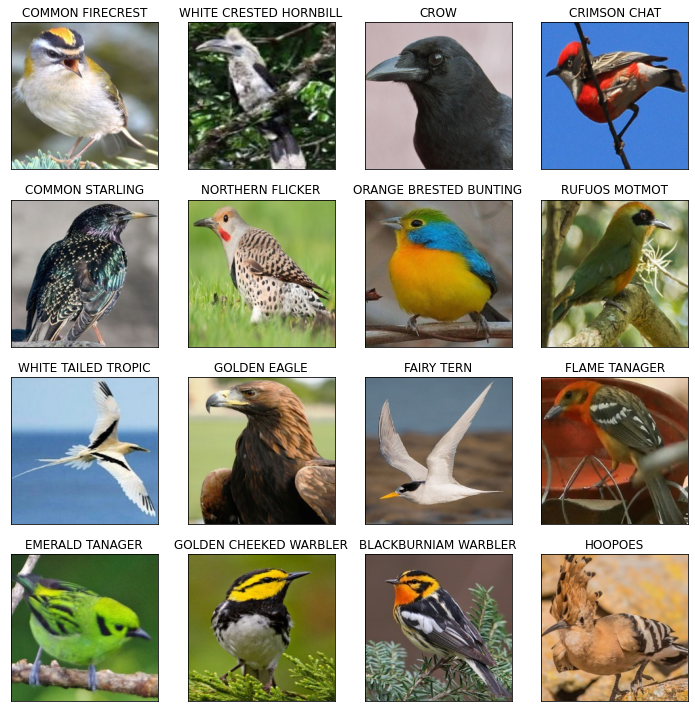

In [63]:
random_index = np.random.randint(0, len(df_train), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_train.Filepath[random_index[i]]))
    ax.set_title(df_train.Species[random_index[i]])
plt.tight_layout()
plt.show()

In [7]:
# Combining files to make a new split
def move_files(source, destination, source_name):
    for root, _, files in os.walk(source):
        for file in files:
            file_path = os.path.join(root, file)
            relative_path = os.path.relpath(file_path, source)
            dest_path = os.path.join(destination, relative_path)
            dest_dir = os.path.dirname(dest_path)

            if not os.path.exists(dest_dir):
                os.makedirs(dest_dir)

            # Get the filename and extension
            file_name, file_extension = os.path.splitext(file)
            new_file_name = f"{source_name}_{file_name}{file_extension}"

            dest_path_with_name = os.path.join(dest_dir, new_file_name)

            shutil.move(file_path, dest_path_with_name)

# Move files from valid and test folders to train folder
move_files(valid_dir, train_dir, 'valid')
move_files(test_dir, train_dir, 'test')

In [12]:
train_folder = os.listdir(train_dir)
train_names = []
train_labels = []
train_images_height = []
train_images_width = []
train_images_color = []
train_names, train_labels, train_images_height, train_images_width, train_images_color = get_data(train_dir, train_folder, train_names, train_labels, train_images_height, train_images_width, train_images_color)
df_train_info = pd.DataFrame({"Species Name": train_labels, "Filepath": train_names})

In [13]:
df_train_info.groupby('Species Name')['Filepath'].nunique().sort_values()

Species Name
EURASIAN GOLDEN ORIOLE     140
RED TAILED THRUSH          140
SNOWY PLOVER               140
AMETHYST WOODSTAR          140
PATAGONIAN SIERRA FINCH    140
                          ... 
ASIAN GREEN BEE EATER      230
D-ARNAUDS BARBET           243
OVENBIRD                   243
HOUSE FINCH                258
RUFOUS TREPE               273
Name: Filepath, Length: 525, dtype: int64

In [9]:
# Increase images for each class to 263 since thats the max number for any class.
target_num_images = 273

# Loop through each class folder and perform augmentation
for folder in train_folder:
    class_path = os.path.join(train_dir, folder)
    
    # Calculate the number of images in the class folder
    images_count = len(os.listdir(class_path))
    
    if images_count < target_num_images:
        # Create an Augmentor pipeline for the class folder
        p = Augmentor.Pipeline(class_path)
        
        # Define augmentation operations (you can modify these as needed)
        p.rotate(probability=0.7, max_left_rotation=25, max_right_rotation=25)
        p.flip_left_right(probability=0.5)
        p.zoom_random(probability=0.5, percentage_area=0.8)
        # Add more augmentation operations
        
        # Keep augmenting until the desired number of images is reached
        num_augmented_images = target_num_images - images_count
        p.sample(num_augmented_images)

Initialised with 272 image(s) found.
Output directory set to birds/train/TURKEY VULTURE/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7FC343C1E2E0>: 100%|███████████████████████████| 1/1 [00:00<00:00, 92.64 Samples/s]


In [6]:
# Augmented images were saved to an output folder this moves them to parent folder
for folder in train_folder:
    class_path = os.path.join(train_dir, folder)
    output_folder = os.path.join(class_path, 'output')  # Path to the output folder
    
    if os.path.exists(output_folder):
        # Loop through images in the output folder
        for image_file in os.listdir(output_folder):
            # Move images to the parent class folder
            src = os.path.join(output_folder, image_file)
            dst = os.path.join(class_path, image_file)
            shutil.move(src, dst)
        
        # Remove the empty output folder
        os.rmdir(output_folder)